In [162]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import scipy.cluster.hierarchy as sch
import statsmodels.api as sm

from helper_files.etv_model import ETVModel
from helper_files.plotting_functions import generate_cp_grid
from adjustText import adjust_text
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from metrics_config import *
from helper_files.helper_files_metrics import *
from tqdm import tqdm
tqdm.pandas()

In [322]:
models = joblib.load('../data/models/xgb_models_auc.jblb')
data_path = '../data/processed/data_1003.jblb'
DATA = joblib.load(data_path)['df']
## exclusion criteria if desired
# grouped = DATA.groupby(['thrower', 'year']).size().reset_index(name='count')
# valid_groups = grouped[grouped['count'] >= 25]
# DATA = DATA.merge(valid_groups[['thrower', 'year']], on=['thrower', 'year'], how='inner')
# grouped = DATA.groupby(['thrower']).year.nunique().reset_index(name='count')
# valid_groups = grouped[grouped['count'] >= 3]
# DATA = DATA.merge(valid_groups[['thrower']], on=['thrower'], how='inner')
etv_model = ETVModel(models['cp_model'], models['fv_model'])
cp, fv_preds_start, fv_preds_end, fv_preds_opponent, etv_preds = etv_model.predict(DATA[models['cp_model']['features']], etv_only=False)
DATA[['cp', 'fv_start', 'fv_end', 'fv_opponent', 'etv']] = list(zip(cp, fv_preds_start, fv_preds_end, fv_preds_opponent, etv_preds))


In [323]:
fv_scaler = models['etv_model'].fv_scaler
cp_scaler = models['etv_model'].cp_scaler
thrower_fv_features = models['fv_model']['features']
cp_features = models['cp_model']['features']
receiver_fv_features = [x.replace('thrower', 'receiver') for x in models['fv_model']['features']]
DATA['thrower_fv'] = models['fv_model']['model'].predict_proba(fv_scaler.transform(DATA[thrower_fv_features]))[:,1]
DATA['receiver_fv'] = models['fv_model']['model'].predict_proba(fv_scaler.transform(DATA[receiver_fv_features].values))[:,1]
DATA.loc[DATA.receiver_y > 100, 'receiver_fv'] = 1
DATA['ec'] = DATA['receiver_fv'] - DATA['thrower_fv']
DATA.loc[DATA['turnover'] == 1, 'ec'] = -(DATA['fv_opponent'])
DATA['cpoe'] = np.where(DATA['completion'] == 1, 1 - DATA['cp'], 0 - DATA['cp'])
DATA.ec = DATA.ec.clip(-1,1)
DATA = DATA.sort_values(['gameID', 'home_team_score', 'away_team_score', 'possession_num', 'game_quarter'])
first_fv = DATA.groupby(['gameID', 'home_team_score', 'away_team_score', 'possession_num', 'game_quarter'])['thrower_fv'].transform('first')
DATA['r_etv'] = np.where(DATA['completion'] == 1, DATA['cp'] * (DATA['receiver_fv']), -((1 - DATA['cp'])) * DATA['fv_opponent'])
DATA['a_ec'] = (DATA['receiver_fv'] - DATA['thrower_fv']) / (1 - first_fv)
DATA.loc[DATA['turnover'] == 1, 'a_ec'] = -(DATA['fv_opponent'])
DATA.a_ec = DATA.a_ec.clip(-1,1)

/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [332]:
# Run the function on your dataframe DATA
stats = ['etv', 'ec', 'a_ec', 'cp']
player_game_season_stats = create_stats(DATA, stats)
player_game_season_stats = player_game_season_stats.rename({'thrower_cp_mean':'xcomp'}, axis=1)
player_game_season_stats = player_game_season_stats[player_game_season_stats.groupby(['player', 'year'])['completions'].transform('sum') >= 10].reset_index(drop=True)
metrics = list(player_game_season_stats.columns[3:])
resampled_player_season_variance = (pivot_metric_columns(player_game_season_stats, metrics).groupby(['year', 'player', 'metric']).agg(bv=('value', lambda x: x.var(ddof=0))) )
bv = (resampled_player_season_variance.groupby(['year', 'metric']).agg(bv=('bv', 'mean')).reset_index())
pivoted_player_season_stats = pivot_metric_columns(player_game_season_stats, metrics)
sv = (pivoted_player_season_stats.groupby(['year', 'metric']).agg(sv=('value', lambda x: x.var(ddof=0))).reset_index().sort_values(by=['year', 'metric']))
discrimination_stats = calculate_discrimination(bv, sv)
wv_stats = calculate_within_player_variance(player_game_season_stats, metrics)
tv_stats = calculate_total_variance(player_game_season_stats, metrics)
stability_stats = calculate_stability(bv, tv_stats, wv_stats)

/Users/bradeneberhard/xai3_modules/Expected Throw Value/meta_metrics/helper_files_metrics.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_throws[yard_col] = successful_throws['receiver_y'].clip(0, 100) - successful_throws['thrower_y']
/Users/bradeneberhard/xai3_modules/Expected Throw Value/meta_metrics/helper_files_metrics.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_throws[yard_col] = successful_throws['receiver_y'].clip(0, 100) - successful_throws['thrower_y']


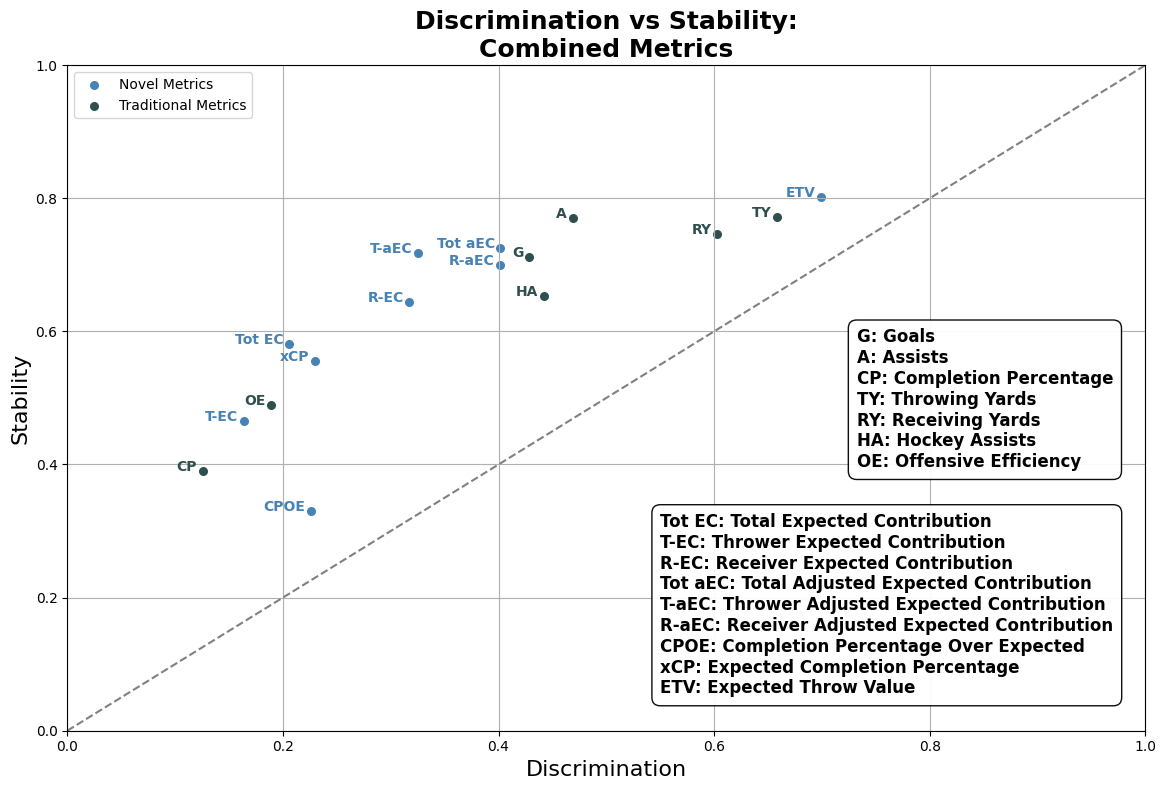

In [233]:
# Abbreviations and new names for metrics
abbreviations_1 = {
    'total_ec': 'Tot EC',
    'total_a_ec': 'Tot aEC',
    'thrower_a_ec_sum': 'T-aEC',
    'thrower_ec_sum': 'T-EC',
    'receiver_a_ec_sum': 'R-aEC',
    'receiver_ec_sum': 'R-EC',
    'cpoe': 'CPOE',
    'xcomp': 'xCP',
    'thrower_etv_sum': 'ETV',
    'thrower_ec_n_sum': 'T-ECn'
}

new_names = {
    'Total Expected Contribution': 'Tot EC',
    'Thrower Expected Contribution': 'T-EC',
    'Receiver Expected Contribution': 'R-EC',
    'Total Adjusted Expected Contribution': 'Tot aEC',
    'Thrower Adjusted Expected Contribution': 'T-aEC',
    'Receiver Adjusted Expected Contribution': 'R-aEC',
    'Completion Percentage Over Expected': 'CPOE',
    'Expected Completion Percentage': 'xCP',
    'Expected Throw Value': 'ETV'
}

abbreviations_2 = {
    'goals': 'G',
    'assists': 'A',
    'completion_percentage': 'CP',
    'throwing_yards': 'TY',
    'receiving_yards': 'RY',
    'hockey_assists': 'HA',
    'offensive_efficiency': 'OE',
}

# Metrics for the second dataset
metrics_2 = [
    'goals', 'assists', 'completion_percentage',
    'throwing_yards', 'receiving_yards', 'hockey_assists', 'offensive_efficiency'
]

# Merging datasets
merged_df_1 = pd.merge(
    discrimination_stats[discrimination_stats.metric.isin(list(abbreviations_1.keys()))].groupby(['metric']).mean()['discrimination'],
    stability_stats, on='metric'
)

merged_df_2 = pd.merge(
    discrimination_stats[discrimination_stats.metric.isin(metrics_2)].groupby(['metric']).mean()['discrimination'],
    stability_stats, on='metric'
)
color2 = 'darkslategray'
color1 = 'steelblue'
# Plot
plt.figure(figsize=(12, 8))
scatter_1 = plt.scatter(merged_df_1['discrimination'] + 0.005, merged_df_1['stability'], color=color1, s=30, label="Novel Metrics")
scatter_2 = plt.scatter(merged_df_2['discrimination'] + 0.005, merged_df_2['stability'], color=color2, s=30, label="Traditional Metrics")

# Adding text labels
for _, row in merged_df_1.iterrows():
    plt.text(row['discrimination'], row['stability'], abbreviations_1.get(row['metric'], row['metric']), fontsize=10, fontweight='bold', ha='right', color=color1)

for _, row in merged_df_2.iterrows():
    plt.text(row['discrimination'], row['stability'], abbreviations_2.get(row['metric'], row['metric']), fontsize=10, fontweight='bold', ha='right', color=color2)

# Plot title and labels
plt.title('Discrimination vs Stability:\nCombined Metrics', fontsize=18, fontweight='bold', ha='center')
plt.xlabel('Discrimination', fontsize=16)
plt.ylabel('Stability', fontsize=16)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Legend
plt.legend(loc="upper left")

# Create text boxes
abbreviation_text_1 = "\n".join([f"{new_names.get(metric, metric).replace('_', ' ')}: {metric.replace('_', ' ').title()}" 
                                 for metric in new_names.keys()])

abbreviation_text_2 = "\n".join([f"{abbreviations_2.get(metric, metric).replace('_', ' ')}: {metric.replace('_', ' ').title()}" 
                                 for metric in metrics_2])

plt.text(0.55, 0.05, abbreviation_text_1, transform=plt.gca().transAxes, fontsize=12, fontweight='bold', 
         verticalalignment='bottom', horizontalalignment='left', 
         bbox=dict(facecolor='white', alpha=0.95, edgecolor='black', boxstyle='round,pad=0.5'))

plt.text(0.7322, 0.39, abbreviation_text_2, transform=plt.gca().transAxes, fontsize=12, fontweight='bold', 
         verticalalignment='bottom', horizontalalignment='left', 
         bbox=dict(facecolor='white', alpha=0.95, edgecolor='black', boxstyle='round,pad=0.5'))

plt.grid(True)
plt.tight_layout()
plt.show()


In [235]:
metrics_data = player_game_season_stats[[x for x in baseline_metrics if x in player_game_season_stats]]
metrics_data = metrics_data.fillna({
    'completion_percentage': metrics_data['completion_percentage'].mean(),
    'offensive_efficiency': metrics_data['offensive_efficiency'].mean()
}).fillna(0)
other_metrics = ['xcomp', 'cpoe', 'thrower_a_ec_sum', 'receiver_a_ec_sum', 'total_a_ec', 'thrower_ec_sum', 'receiver_ec_sum', 'total_ec', 'thrower_etv_sum']

independence_scores = {}
explained_variances = {}

for metric in other_metrics:
    model = sm.OLS(player_game_season_stats[metric].fillna(0), sm.add_constant(metrics_data)).fit()
    independence_scores[metric] = 1 - model.rsquared
    explained_variances[metric] = player_game_season_stats[metric].var()

total_variance = sum(explained_variances.values())
explained_variances = {metric: var / total_variance for metric, var in explained_variances.items()}

independence_df = pd.DataFrame({
    'metric': independence_scores.keys(),
    'independence_score': independence_scores.values(),
    # 'explained_variance': explained_variances.values()
}).sort_values(by='independence_score', ascending=False)

independence_df


,metric,independence_score
1,cpoe,0.998160
0,xcomp,0.826663
6,receiver_ec_sum,0.635619
2,thrower_a_ec_sum,0.510935
3,receiver_a_ec_sum,0.497888
4,total_a_ec,0.405709
7,total_ec,0.363794
5,thrower_ec_sum,0.326982
8,thrower_etv_sum,0.012219


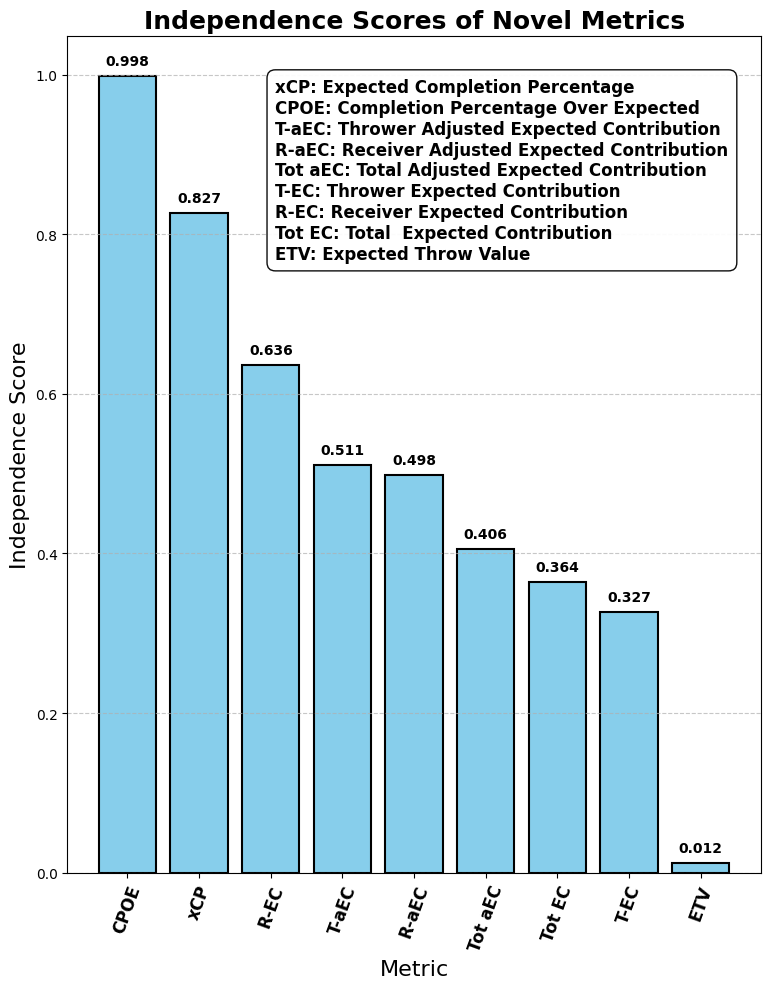

In [239]:
abbreviations = {
    'total_ec': 'Tot EC',
    'total_a_ec': 'Tot aEC',
    'thrower_a_ec_sum': 'T-aEC',
    'thrower_ec_sum': 'T-EC',
    'receiver_a_ec_sum': 'R-aEC',
    'receiver_ec_sum': 'R-EC',
    'cpoe': 'CPOE',
    'xcomp': 'xCP',
    'thrower_etv_sum': 'ETV',
    'thrower_ec_n_sum': 'T-ECn'
}

custom_names = {
    'Expected Completion Percentage': 'xCP',
    'Completion Percentage Over Expected': 'CPOE',
    'Thrower Adjusted Expected Contribution': 'T-aEC',
    'Receiver Adjusted Expected Contribution': 'R-aEC',
    'Total Adjusted Expected Contribution': 'Tot aEC',
    'Thrower Expected Contribution': 'T-EC',
    'Receiver Expected Contribution': 'R-EC',
    'Total  Expected Contribution': 'Tot EC',
    'Expected Throw Value': 'ETV',
}

plt.figure(figsize=(8, 10))

bars = plt.bar(independence_df['metric'], independence_df['independence_score'], color='skyblue', edgecolor='black', linewidth=1.5)

plt.xlabel('Metric', fontsize=16)
plt.ylabel('Independence Score', fontsize=16)
plt.title('Independence Scores of Novel Metrics', fontsize=18, fontweight='bold')

# Define the tick positions
tick_positions = range(len(independence_df['metric']))

# Set custom labels using the abbreviations dictionary
plt.xticks(tick_positions, [abbreviations.get(x, x) for x in independence_df['metric']], rotation=70, fontsize=12, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Create custom legend with abbreviations and custom names

abbreviation_text = "\n".join([f"{abb.replace('_', ' ')}: {metric.replace('_', ' ')}" 
                              for metric, abb in custom_names.items()])
plt.text(0.3, 0.95, abbreviation_text, transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
         verticalalignment='top', horizontalalignment='left', 
         bbox=dict(facecolor='white', alpha=0.95, edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()



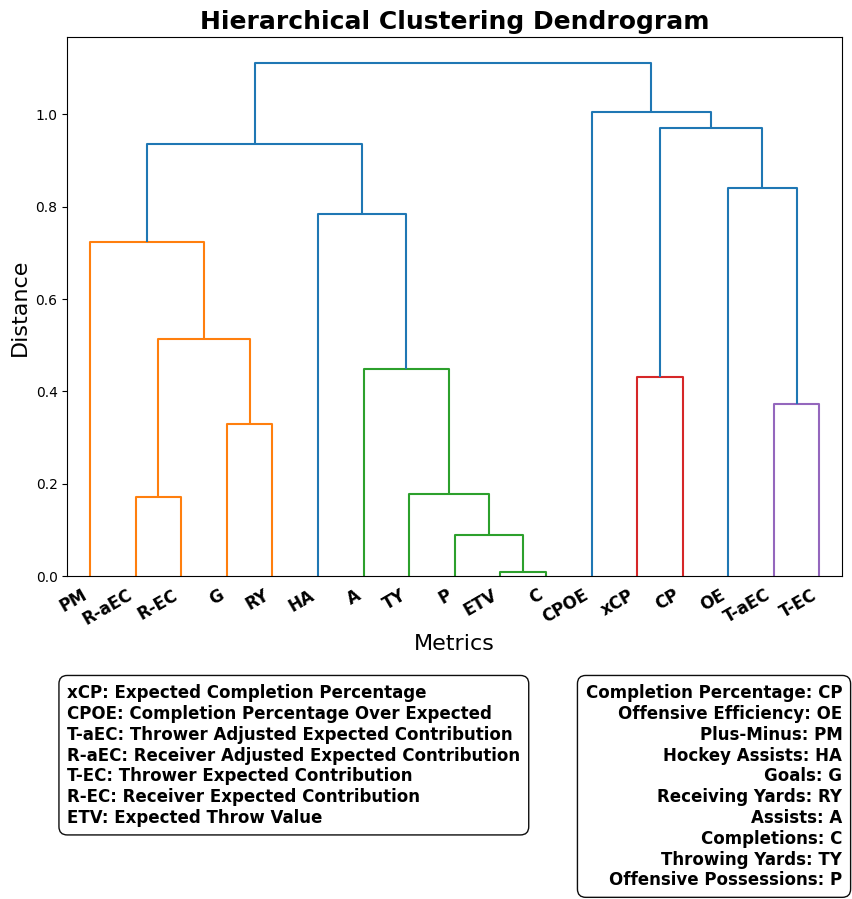

In [173]:
conventional_abbreviations = {
    'completion_percentage': 'CP',
    'offensive_efficiency': 'OE',
    'plus_minus': 'PM',
    'hockey_assists': 'HA',
    'goals': 'G',
    'receiving_yards': 'RY',
    'assists': 'A',
    'completions': 'C',
    'throwing_yards': 'TY',
    'offensive_possessions': 'P'
}

conventional_new_names = {
    'CP': 'Completion Percentage',
    'OE': 'Offensive Efficiency',
    'PM': 'Plus-Minus',
    'HA': 'Hockey Assists',
    'G': 'Goals',
    'RY': 'Receiving Yards',
    'A': 'Assists',
    'C': 'Completions',
    'TY': 'Throwing Yards',
    'P': 'Offensive Possessions',
}

novel_abbreviations = {
    'xcomp': 'xCP',
    'cpoe': 'CPOE',
    'thrower_a_ec_sum': 'T-aEC',
    'receiver_a_ec_sum': 'R-aEC',
    'thrower_ec_sum': 'T-EC',
    'receiver_ec_sum': 'R-EC',
    'thrower_etv_sum': 'ETV',
}

novel_new_names = {
    'Expected Completion Percentage': 'xCP',
    'Completion Percentage Over Expected': 'CPOE',
    'Thrower Adjusted Expected Contribution': 'T-aEC',
    'Receiver Adjusted Expected Contribution': 'R-aEC',
    'Thrower Expected Contribution': 'T-EC',
    'Receiver Expected Contribution': 'R-EC',
    'Expected Throw Value': 'ETV'
}

ind_metrics = ['xcomp', 'cpoe', 'thrower_a_ec_sum', 'receiver_a_ec_sum', 'thrower_ec_sum', 'receiver_ec_sum', 'thrower_etv_sum']
features = ['completion_percentage', 'offensive_efficiency', 'hockey_assists', 'plus_minus', 'goals', 'receiving_yards', 'assists', 'throwing_yards', 'completions', 'offensive_possessions']
features = ind_metrics + features
# Assuming you have already calculated the correlation matrix
metrics_data = player_game_season_stats[features]
correlation_matrix = metrics_data.corr()

# Step 2: Convert the correlation matrix to a distance matrix
# Distance = 1 - correlation
distance_matrix = 1 - correlation_matrix

# Step 3: Perform hierarchical clustering
# Use 'average', 'single', 'complete', or other linkage methods as appropriate
Z = sch.linkage(sch.distance.squareform(distance_matrix), method='complete')
novel_abbreviation_text = "\n".join([f"{novel_new_names.get(metric, metric).replace('_', ' ')}: {metric.replace('_', ' ').title()}" 
                              for metric in novel_new_names.keys()])

conventional_abbreviation_text = "\n".join([f"{conventional_new_names.get(metric, metric).replace('_', ' ')}: {metric.replace('_', ' ')}" 
                              for metric in conventional_new_names.keys()])
# Step 4: Plot the dendrogram
abbreviated_labels = [novel_abbreviations.get(label, conventional_abbreviations.get(label, label)) 
                      for label in correlation_matrix.columns]

# Step 4: Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z, labels=abbreviated_labels) 
plt.title('Hierarchical Clustering Dendrogram', fontsize=18, fontweight='bold', ha='center')
plt.xlabel('Metrics', fontsize=16)
plt.ylabel('Distance', fontsize=16)
plt.xticks(rotation=30, ha='right', fontweight='bold')
plt.text(0, -0.2, novel_abbreviation_text, transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
         verticalalignment='top', horizontalalignment='left', 
         bbox=dict(facecolor='white', alpha=0.95, edgecolor='black', boxstyle='round,pad=0.5'))

plt.text(1, -0.2, conventional_abbreviation_text, transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
         verticalalignment='top', horizontalalignment='right', 
         bbox=dict(facecolor='white', alpha=0.95, edgecolor='black', boxstyle='round,pad=0.5'))

plt.show()


In [194]:
player_game_season_stats.groupby(['player', 'year']).total_ec.sum().sort_values().tail(5).to_csv('./tables/total_ec.csv')
player_game_season_stats.groupby(['player', 'year']).total_a_ec.sum().sort_values().tail(5).to_csv('./tables/total_a_ec.csv')
player_game_season_stats.groupby(['player', 'year']).thrower_ec_sum.sum().sort_values().tail(5).to_csv('./tables/thrower_ec.csv')
player_game_season_stats.groupby(['player', 'year']).thrower_a_ec_sum.sum().sort_values().tail(5).to_csv('./tables/thrower_a_ec.csv')
player_game_season_stats.groupby(['player', 'year']).receiver_ec_sum.sum().sort_values().tail(5).to_csv('./tables/receiver_ec.csv')
player_game_season_stats.groupby(['player', 'year']).receiver_a_ec_sum.sum().sort_values().tail(5).to_csv('./tables/receiver_a_ec.csv')